# Data preprocessing

In [140]:
# __author__: Jingquan Wang

In [141]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors as _rdMolDescriptors
DATA_PATH = "./data"

## Generate features based on SMILES strings

### 1. 2D molecule descriptors from RDKit

List of descriptors (2D):

|Index|Descriptor|Notes|Func|
|:---|:---|:---|:---|
|1|atomic mass high|Pearlman and Smith in “3D-QSAR and Drug design: Recent Advances” (1997)|rdMolDescriptors.BCUT2D(mol) -> rdkit.rdBase._vectd|
|2|atomic mass low|~||
|3|gasteiger charge high|~||
|4|gasteiger charge low|~||
|5|crippen logp high|~||
|6|crippen logp low|~||
|7|crippen mr high|~||
|8|crippen mr low|~||
|9|*Autocorr2D|Todeschini and Consoni “Descriptors from Molecular Geometry” Handbook of Chemoinformatics https://doi.org/10.1002/9783527618279.ch37|rdMolDescriptors.CalcAUTOCORR2D(mol) -> list|
|10-14|chi0n - 4n|Rev.Comput.Chem. 2:367-422 (1991)|rdMolDescriptors.CalcChiNn(mol, N) -> float|
|15-19|chi0v - 4v|~|rdMolDescriptors.CalcChiNv(mol, N) -> float|
|20|MolLogP|Wildman and Crippen JCICS 39:868-73 (1999)|rdMolDescriptors.CalcCrippenDescriptors(mol) -> tuple|
|21|MolMR|~|~|
|22|ExactMolWt||rdMolDescriptors.CalcExactMolWt(mol) -> float|
|23|FractionCSP3|Fraction of C atoms that are SP3 hybridized|rdMolDescriptors.CalcFractionCSP3(mol) -> float|
|24|HallKierAlpha|Rev.Comput.Chem. 2:367-422 (1991)|rdMolDescriptors.CalcHallKierAlpha(mol) -> float|
|25-27|Kappa1-3|Rev.Comput.Chem. 2:367-422 (1991)|rdMolDescriptors.CalcKappa1/2/3(mol) -> float|
|28|LabuteASA|J.Mol.Graph.Mod. 18:464-77 (2000)|rdMolDescriptors.CalcLabuteASA(mol) -> float|
|29-35|Num{Aromatic,Saturated,Aliphatic}{Hetero,Carbo}cycles||rdMolDescriptors.CalcNum{Aromatic/Saturated/Aliphatic}{Hetero/Carbo}cycles -> int|
|36-39|Num{Aromatic,Saturated,Aliphatic}Rings||rdMolDescriptors.CalcNum{Aromatic/Saturated/Aliphatic/None}Rings(mol) -> int|
|40|NumAtomStereoCenters|The total number of atomic stereocenters|rdMolDescriptors.CalcNumAtomStereoCenters(mol) -> int|
|41|NumBridgeheadAtoms|Number of bridgehead atoms (atoms shared between rings that share at least two bonds)|rdMolDescriptors.CalcNumBridgeheadAtoms(mol) -> int|
|42|NumHBA|The number of H-bond acceptors|rdMolDescriptors.CalcNumHBA(mol) -> int|
|43|NumHBD|The number of H-bond donors for a molecule|rdMolDescriptors.CalcNumHBD(mol) -> int|
|44|NumHeteroatoms||rdMolDescriptors.CalcNumHeteroatoms(mol) -> int|
|45|NumLipinskiHBA|Number of Lipinski H-bond acceptors|rdMolDescriptors.CalcNumLipinskiHBA(mol) -> int|
|46|NumLipinskiHBD|Number of Lipinski H-bond donors|rdMolDescriptors.CalcNumLipinskiHBD(mol) -> int|
|47|NumRotatableBonds||rdMolDescriptors.CalcNumRotatableBonds(mol) -> int|
|48|NumSpiroAtoms|Number of spiro atoms (atoms shared between rings that share exactly one at7m)|rdMolDescriptors.CalcNumSpiroAtoms(mol) -> int|
|49|TPSA|J.Med.Chem. 43:3714-7, (2000)|rdMolDescriptors.CalcTPSA(mol) -> float|
|50-63|PEOE_VSA1 - PEOE_VSA14|MOE-type descriptors using partial charges and surface area contributions http://www.chemcomp.com/journal/vsadesc.htm|rdMolDescriptors.PEOE_VSA_(mol) -> list|
|64-73|SMR_VSA1 - SMR_VSA10|MOE-type descriptors using MR contributions and surface area contributions http://www.chemcomp.com/journal/vsadesc.htm|rdMolDescriptors.SMR_VSA_(mol) -> list|
|74-85|SlogP_VSA1 - SlogP_VSA12|MOE-type descriptors using LogP contributions and surface area contributions http://www.chemcomp.com/journal/vsadesc.htm|rdMolDescriptors.SlogP_VSA_(mol) -> list|
|86-127|MQNs|Nguyen et al. ChemMedChem 4:1803-5 (2009)|rdMolDescriptors.MQNs_ -> list|

In [157]:
def rdk_features(smi: str) -> list:
    '''
    Main featurization function
    '''
    mol = Chem.MolFromSmiles(smi)
    bcut2d = _rdMolDescriptors.BCUT2D(mol) # rdkit.rdBase._vectd, len=8
    chiNn = [_rdMolDescriptors.CalcChiNn(mol, i) for i in range(5)] # list, len=5
    chiNv = [_rdMolDescriptors.CalcChiNv(mol, i) for i in range(5)] # list, len=5
    mollogp, molmr = _rdMolDescriptors.CalcCrippenDescriptors(mol) # floats
    molwt = _rdMolDescriptors.CalcExactMolWt(mol) # float
    csp3 = _rdMolDescriptors.CalcFractionCSP3(mol) # float
    hka = _rdMolDescriptors.CalcHallKierAlpha(mol) # float
    kappa = [
        _rdMolDescriptors.CalcKappa1(mol),
        _rdMolDescriptors.CalcKappa2(mol),
        _rdMolDescriptors.CalcKappa3(mol)
    ] # list, len=3
    labuteasa = _rdMolDescriptors.CalcLabuteASA(mol) # float
    num_hetero_cycles = [
        _rdMolDescriptors.CalcNumHeterocycles(mol),
        _rdMolDescriptors.CalcNumAromaticHeterocycles(mol),
        _rdMolDescriptors.CalcNumSaturatedHeterocycles(mol),
        _rdMolDescriptors.CalcNumAliphaticHeterocycles(mol)
    ] # list[int], [total, aromatic, saturated, aliphatic], len=4
    num_carbo_cycles = [
        _rdMolDescriptors.CalcNumAromaticCarbocycles(mol),
        _rdMolDescriptors.CalcNumSaturatedCarbocycles(mol),
        _rdMolDescriptors.CalcNumAliphaticCarbocycles(mol)
    ] # list[int], [total, aromatic, saturated, aliphatic], len=3
    num_rings = [
        _rdMolDescriptors.CalcNumRings(mol),
        _rdMolDescriptors.CalcNumAromaticRings(mol),
        _rdMolDescriptors.CalcNumSaturatedRings(mol),
        _rdMolDescriptors.CalcNumAliphaticRings(mol)
    ] # list[int], [total, aromatic, saturated, aliphatic], len=4
    num_stereo_centers = _rdMolDescriptors.CalcNumAtomStereoCenters(mol) # int
    num_bridgehead_atoms = _rdMolDescriptors.CalcNumBridgeheadAtoms(mol) # int
    num_hba = _rdMolDescriptors.CalcNumHBA(mol) # int
    num_hbd = _rdMolDescriptors.CalcNumHBD(mol) # int
    num_hetero_atom = _rdMolDescriptors.CalcNumHeteroatoms(mol) # int
    num_lipinski_hba = _rdMolDescriptors.CalcNumLipinskiHBA(mol) # int
    num_lipinski_hbd = _rdMolDescriptors.CalcNumLipinskiHBD(mol) # int
    num_rot_bonds = _rdMolDescriptors.CalcNumRotatableBonds(mol) # int
    num_spiro_atoms = _rdMolDescriptors.CalcNumSpiroAtoms(mol) # int
    tpsa = _rdMolDescriptors.CalcTPSA(mol) # float
    peoe_vsa = _rdMolDescriptors.PEOE_VSA_(mol) # list, len=14
    smr_vsa = _rdMolDescriptors.SMR_VSA_(mol) # list, len=10
    slogp_vsa = _rdMolDescriptors.SlogP_VSA_(mol) # list, len=12
    mqn = _rdMolDescriptors.MQNs_(mol) # list, len=42

    
    feats = [ele for ele in bcut2d] +\
            chiNn +\
            chiNv +\
            [mollogp, molmr, molwt, csp3, hka] +\
            kappa +\www
            [labuteasa]+\
            num_hetero_cycles +\
            num_carbo_cycles +\
            num_rings +\
            [num_stereo_centers, num_bridgehead_atoms, num_hba, num_hbd] +\
            [num_hetero_atom, num_lipinski_hba, num_lipinski_hbd] +\
            [num_rot_bonds, num_spiro_atoms, tpsa]+\
            peoe_vsa +\
            smr_vsa +\
            slogp_vsa +\
            mqn
            
    return feats

feats = rdk_features("COc1ccccc1c2cccc(NC(=O)C(Cl)Cl)c2")
print(len(feats), cfeats)

126 [35.53916845786897, 10.039695552306997, 2.1182915386175223, -2.104646725651432, 2.3054917848004792, -2.17916617759252, 6.540758862942545, -0.11417671130813835, 20.0, 5.94032497023007, 4.0710354258458885, 2.746283230851713, 1.844425365262011, 20.0, 6.813196531174039, 5.167300085391731, 3.1426752823626556, 1.9535343103800074, 4.104400000000002, 82.55370000000002, 309.03233401600005, 0.13333333333333333, -1.71, 14.693972974229522, 6.638286463373893, 3.4364376203332885, 127.01478563567285, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 2, 1, 5, 3, 1, 4, 0, 38.33, 10.05365155780638, 4.794537184071822, 0.0, 0.0, 0.0, 53.53371512277308, 23.762552697081826, 11.250837766380558, 7.109797541277533, 5.749511833283905, 4.836269690250055, 0.0, 5.907179729351506, 0.0, 9.53140013787187, 0.0, 0.0, 0.0, 4.836269690250055, 12.426586145283864, 48.53093654769288, 0.0, 16.876414816677897, 34.7964457845001, 10.05365155780638, 17.853246960879094, 4.794537184071822, 0.0, 0.0, 48.53093654769288, 0.0, 11.12690298339

In [158]:
feats_name = [
    'atomic_mass_high',
    'atomic_mass_low',
    'gasteiger_charge_high',
    'gasteiger_charge_low',
    'crippen_logp_high',
    'crippen_logp_low',
    'crippen_mr_high',
    'crippen_mr_low',
    'chi0n',
    'chi1n',
    'chi2n',
    'chi3n',
    'chi4n',
    'chi0v',
    'chi1v',
    'chi2v',
    'chi3v',
    'chi4v',
    'MolLogP',
    'MolMR',
    'ExactMolWt',
    'FractionCSP3',
    'HallKierAlpha',
    'Kappa1',
    'Kappa2',
    'Kappa3',
    'LabuteASA',
    'NumHeterocycles',
    'NumAromaticHeterocycles',
    'NumSaturatedHeterocycles',
    'NumAliphaticHeterocycles',
    'NumAromaticCarbocycles',
    'NumSaturatedCarbocycles',
    'NumAliphaticCarbocycles',
    'NumRings',
    'NumAromaticRings',
    'NumSaturatedRings',
    'NumAliphaticRings',
    'NumAtomStereoCenters',
    'NumBridgeheadAtoms',
    'NumHBA',
    'NumHBD',
    'NumHeteroatoms',
    'NumLipinskiHBA',
    'NumLipinskiHBD',
    'NumRotatableBonds',
    'NumSpiroAtoms',
    'TPSA',
    'PEOE_VSA1',
    'PEOE_VSA2',
    'PEOE_VSA3',
    'PEOE_VSA4',
    'PEOE_VSA5',
    'PEOE_VSA6',
    'PEOE_VSA7',
    'PEOE_VSA8',
    'PEOE_VSA9',
    'PEOE_VSA10',
    'PEOE_VSA11',
    'PEOE_VSA12',
    'PEOE_VSA13',
    'PEOE_VSA14',
    'SMR_VSA1',
    'SMR_VSA2',
    'SMR_VSA3',
    'SMR_VSA4',
    'SMR_VSA5',
    'SMR_VSA6',
    'SMR_VSA7',
    'SMR_VSA8',
    'SMR_VSA9',
    'SMR_VSA10',
    'SlogP_VSA1',
    'SlogP_VSA2',
    'SlogP_VSA3',
    'SlogP_VSA4',
    'SlogP_VSA5',
    'SlogP_VSA6',
    'SlogP_VSA7',
    'SlogP_VSA8',
    'SlogP_VSA9',
    'SlogP_VSA10',
    'SlogP_VSA11',
    'SlogP_VSA12',
    'MQN1',
    'MQN2',
    'MQN3',
    'MQN4',
    'MQN5',
    'MQN6',
    'MQN7',
    'MQN8',
    'MQN9',
    'MQN10',
    'MQN11',
    'MQN12',
    'MQN13',
    'MQN14',
    'MQN15',
    'MQN16',
    'MQN17',
    'MQN18',
    'MQN19',
    'MQN20',
    'MQN21',
    'MQN22',
    'MQN23',
    'MQN24',
    'MQN25',
    'MQN26',
    'MQN27',
    'MQN28',
    'MQN29',
    'MQN30',
    'MQN31',
    'MQN32',
    'MQN33',
    'MQN34',
    'MQN35',
    'MQN36',
    'MQN37',
    'MQN38',
    'MQN39',
    'MQN40',
    'MQN41',
    'MQN42'
]

len(feats_name)

126

### 2. Input data (positives and negatives)

In [160]:
df_pos = pd.read_csv(f"{DATA_PATH}/positive.csv")
df_neg = pd.read_csv(f"{DATA_PATH}/negative.csv")

In [161]:
df_pos.head()

,compound_name,InChl,InChl Key,Canonical SMILES,Isomeric SMILES
0,paclitaxel,InChI=1S/C47H51NO14/c1-25-31(60-43(56)36(52)35...,RCINICONZNJXQF-MZXODVADSA-N,CC1=C2C(C(=O)C3(C(CC4C(C3C(C(C2(C)C)(CC1OC(=O)...,CC1=C2[C@H](C(=O)[C@@]3([C@H](C[C@@H]4[C@]([C@...
1,vincristine,InChI=1S/C46H56N4O10/c1-7-42(55)22-28-23-45(40...,OGWKCGZFUXNPDA-XQKSVPLYSA-N,CCC1(CC2CC(C3=C(CCN(C2)C1)C4=CC=CC=C4N3)(C5=C(...,CC[C@@]1(C[C@@H]2C[C@@](C3=C(CCN(C2)C1)C4=CC=C...
2,LTC4,InChI=1S/C30H47N3O9S/c1-2-3-4-5-6-7-8-9-10-11-...,GWNVDXQDILPJIG-NXOLIXFESA-N,CCCCCC=CCC=CC=CC=CC(C(CCCC(=O)O)O)SCC(C(=O)NCC...,CCCCC/C=C\C/C=C\C=C\C=C\[C@H]([C@H](CCCC(=O)O)...
3,E217bG,InChI=1S/C24H32O8/c1-24-9-8-14-13-5-3-12(25)10...,MTKNDAQYHASLID-QXYWQCSFSA-N,CC12CCC3C(C1CCC2OC4C(C(C(C(O4)C(=O)O)O)O)O)CCC...,C[C@]12CC[C@H]3[C@H]([C@@H]1CC[C@@H]2O[C@H]4[C...
4,gemcitabine,InChI=1S/C9H11F2N3O4/c10-9(11)6(16)4(3-15)18-7...,SDUQYLNIPVEERB-QPPQHZFASA-N,C1=CN(C(=O)N=C1N)C2C(C(C(O2)CO)O)(F)F,C1=CN(C(=O)N=C1N)[C@H]2C([C@@H]([C@H](O2)CO)O)...


In [162]:
df_neg.head()

,compound_name,InChl,InChl Key,Canonical SMILES,Isomeric SMILES
0,﻿Probenecid,"InChI=1S/C13H19NO4S/c1-3-9-14(10-4-2)19(17,18)...",DBABZHXKTCFAPX-UHFFFAOYSA-N,CCCN(CCC)S(=O)(=O)C1=CC=C(C=C1)C(=O)O,NaN
1,cAMP,InChI=1S/C10H12N5O6P/c11-8-5-9(13-2-12-8)15(3-...,IVOMOUWHDPKRLL-KQYNXXCUSA-N,C1C2C(C(C(O2)N3C=NC4=C(N=CN=C43)N)O)OP(=O)(O1)O,C1[C@@H]2[C@H]([C@H]([C@@H](O2)N3C=NC4=C(N=CN=...
2,﻿Glucuronic acid,InChI=1S/C6H10O7/c7-1-2(8)4(5(10)11)13-6(12)3(...,AEMOLEFTQBMNLQ-AQKNRBDQSA-N,C1(C(C(OC(C1O)O)C(=O)O)O)O,[C@@H]1([C@@H]([C@H](OC([C@@H]1O)O)C(=O)O)O)O
3,PSC833,InChI=1S/C63H111N11O12/c1-26-27-28-41(16)53(76...,YJDYDFNKCBANTM-QCWCSKBGSA-N,CC=CCC(C)C(=O)C1C(=O)NC(C(=O)N(CC(=O)N(C(C(=O)...,C/C=C/C[C@@H](C)C(=O)[C@H]1C(=O)N[C@H](C(=O)N(...
4,sn38,InChI=1S/C22H20N2O5/c1-3-12-13-7-11(25)5-6-17(...,FJHBVJOVLFPMQE-QFIPXVFZSA-N,CCC1=C2CN3C(=CC4=C(C3=O)COC(=O)C4(CC)O)C2=NC5=...,CCC1=C2CN3C(=CC4=C(C3=O)COC(=O)[C@@]4(CC)O)C2=...


In [163]:
len(df_pos), len(df_neg)

(53, 63)

### 3. Featurization

In [164]:
# initialize dataset
df_feats = pd.DataFrame(columns=['compound_name', 'y', 'smiles']+feats_name)
df_feats['compound_name'] = df_pos['compound_name'].values.tolist() +\
                            df_neg['compound_name'].values.tolist()
df_feats['y'] = [1] * len(df_pos) + [0] * len(df_neg)
df_feats['smiles'] = df_pos['Canonical SMILES'].values.tolist() +\
                     df_neg['Canonical SMILES'].values.tolist()
df_feats.head()

,compound_name,y,smiles,atomic_mass_high,atomic_mass_low,gasteiger_charge_high,gasteiger_charge_low,crippen_logp_high,crippen_logp_low,crippen_mr_high,...,MQN33,MQN34,MQN35,MQN36,MQN37,MQN38,MQN39,MQN40,MQN41,MQN42
0,paclitaxel,1,CC1=C2C(C(=O)C3(C(CC4C(C3C(C(C2(C)C)(CC1OC(=O)...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,vincristine,1,CCC1(CC2CC(C3=C(CCN(C2)C1)C4=CC=CC=C4N3)(C5=C(...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,LTC4,1,CCCCCC=CCC=CC=CC=CC(C(CCCC(=O)O)O)SCC(C(=O)NCC...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,E217bG,1,CC12CCC3C(C1CCC2OC4C(C(C(C(O4)C(=O)O)O)O)O)CCC...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,gemcitabine,1,C1=CN(C(=O)N=C1N)C2C(C(C(O2)CO)O)(F)F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [166]:
# featurization
for index, row in df_feats.iterrows():
    try:
        feats = rdk_features(row.get('smiles'))
    except TypeError as e:
        print(e)
        print(row['compound_name'], row['smiles'])
    df_feats.loc[index, 'atomic_mass_high':'MQN42'] = feats
    print(f"{row['compound_name']} done!")

df_feats.head()

paclitaxel done!
vincristine done!
LTC4 done!
E217bG done!
gemcitabine done!
araC done!
docetaxel done!
epothiloneB done!
vinblastine done!
vinorelbine done!
tenofovir done!
Lapatinib done!
Erlotinib done!
PD-173074 done!
AlstolucinesB  done!
Nilotinib done!
Vemurafenib done!
Tandutinib done!
BBA done!
Tariquidar done!
Ibrutinib done!
﻿NVP-BHG712 done!
﻿Linsitinib done!
﻿Ponatinib done!
﻿Cepharanthine done!
Imatinib done!
Sildenafil done!
Vardenafil done!
DNP-SG done!
Doxorubicin done!
Sulfinpyrazone done!
﻿Glycolithocholate-3-sulfate done!
MK571 done!
﻿Trequinsin done!
﻿Taurocholate done!
17beta-Estradiol 3-sulfate-17-(beta-D-glucuronide) done!
﻿Zaprinast done!
﻿16alpha,17beta-Estriol 3-sulfate (Estradiol-3-sulfate) done!
﻿17alpha-Ethynyl-17beta-estradiol (Ethinyl estradiol) done!
﻿16alpha,17beta-Estriol 16-(beta-d-glucuronide) done!
﻿Glycocholate done!
﻿16alpha,17beta-Estriol 3-(beta-d-glucuronide) (Estriol 3-glucuronide) done!
﻿17beta-Estradiol 3-(beta-d-glucuronide) done!
﻿17-betaE

,compound_name,y,smiles,atomic_mass_high,atomic_mass_low,gasteiger_charge_high,gasteiger_charge_low,crippen_logp_high,crippen_logp_low,crippen_mr_high,...,MQN33,MQN34,MQN35,MQN36,MQN37,MQN38,MQN39,MQN40,MQN41,MQN42
0,paclitaxel,1,CC1=C2C(C(=O)C3(C(CC4C(C3C(C(C2(C)C)(CC1OC(=O)...,16.6373,9.44359,2.78072,-2.67031,2.64152,-2.81522,5.96099,...,0,1,0,5,0,1,0,0,7,4
1,vincristine,1,CCC1(CC2CC(C3=C(CCN(C2)C1)C4=CC=CC=C4N3)(C5=C(...,16.5771,9.47329,2.80653,-2.62787,2.68076,-2.81168,5.96318,...,0,0,3,5,0,0,1,0,14,9
2,LTC4,1,CCCCCC=CCC=CC=CC=CC(C(CCCC(=O)O)O)SCC(C(=O)NCC...,32.1666,10.0882,2.25419,-2.2308,2.21568,-2.49553,7.99717,...,0,0,0,0,0,0,0,0,0,0
3,E217bG,1,CC12CCC3C(C1CCC2OC4C(C(C(C(O4)C(=O)O)O)O)O)CCC...,16.7121,9.55158,2.56999,-2.51087,2.61469,-2.60996,5.73012,...,0,0,1,4,0,0,0,0,6,3
4,gemcitabine,1,C1=CN(C(=O)N=C1N)C2C(C(C(O2)CO)O)(F)F,19.2859,10.1133,2.58983,-2.20352,2.41368,-2.41351,5.23343,...,0,0,1,1,0,0,0,0,0,0


In [167]:
# Output featurized data
df_feats.to_csv(f"{DATA_PATH}/featurized.csv", index=False)

### 4. Visualization

In [168]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

In [169]:
df_feats = pd.read_csv(f"{DATA_PATH}/featurized.csv")
df_feats.head()

,compound_name,y,smiles,atomic_mass_high,atomic_mass_low,gasteiger_charge_high,gasteiger_charge_low,crippen_logp_high,crippen_logp_low,crippen_mr_high,...,MQN33,MQN34,MQN35,MQN36,MQN37,MQN38,MQN39,MQN40,MQN41,MQN42
0,paclitaxel,1,CC1=C2C(C(=O)C3(C(CC4C(C3C(C(C2(C)C)(CC1OC(=O)...,16.637263,9.443593,2.780724,-2.670310,2.641517,-2.815220,5.960987,...,0,1,0,5,0,1,0,0,7,4
1,vincristine,1,CCC1(CC2CC(C3=C(CCN(C2)C1)C4=CC=CC=C4N3)(C5=C(...,16.577115,9.473290,2.806532,-2.627873,2.680758,-2.811678,5.963184,...,0,0,3,5,0,0,1,0,14,9
2,LTC4,1,CCCCCC=CCC=CC=CC=CC(C(CCCC(=O)O)O)SCC(C(=O)NCC...,32.166622,10.088200,2.254193,-2.230805,2.215675,-2.495532,7.997174,...,0,0,0,0,0,0,0,0,0,0
3,E217bG,1,CC12CCC3C(C1CCC2OC4C(C(C(C(O4)C(=O)O)O)O)O)CCC...,16.712135,9.551578,2.569991,-2.510869,2.614694,-2.609964,5.730115,...,0,0,1,4,0,0,0,0,6,3
4,gemcitabine,1,C1=CN(C(=O)N=C1N)C2C(C(C(O2)CO)O)(F)F,19.285892,10.113260,2.589833,-2.203523,2.413683,-2.413506,5.233434,...,0,0,1,1,0,0,0,0,0,0


In [174]:
def visualize(nrows, ncols, figsize, colnames, title):
    '''
    Function for batch visualization
    '''
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize)
    fig.subplots_adjust(wspace=0.5)
    fig.suptitle(title)
    vi = 0
    if not isinstance(axs, np.ndarray):
        sns.boxplot(x=df_feats["y"], 
                    y=df_feats[colnames[vi]], 
                    palette="muted",
                    ax=axs)
    else:
        for ax in axs.flatten():
            sns.boxplot(x=df_feats["y"], 
                        y=df_feats[colnames[vi]], 
                        palette="muted",
                        ax=ax)
            vi += 1
    plt.savefig(f"./figs/{title}.png")

#### SlogP_VSA

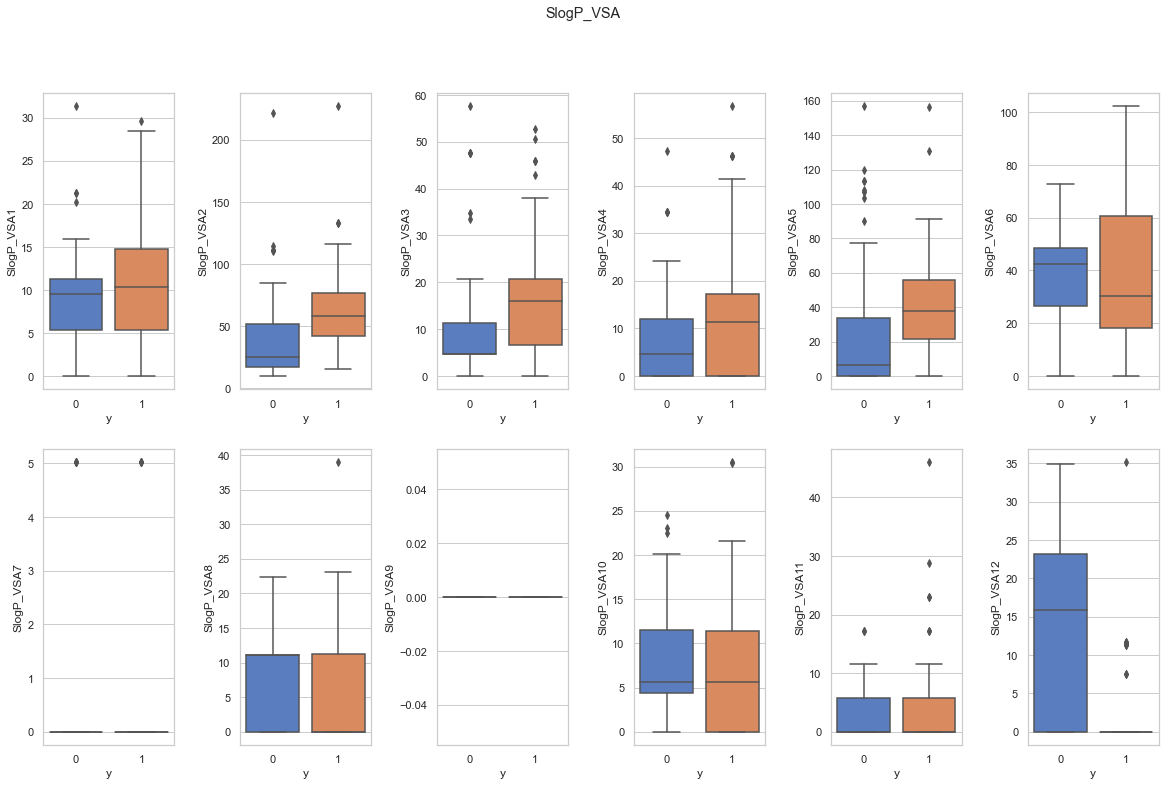

In [128]:
visualize(2, 6, (20, 12), [f'SlogP_VSA{i}' for i in range(1, 13)], 'SlogP_VSA')

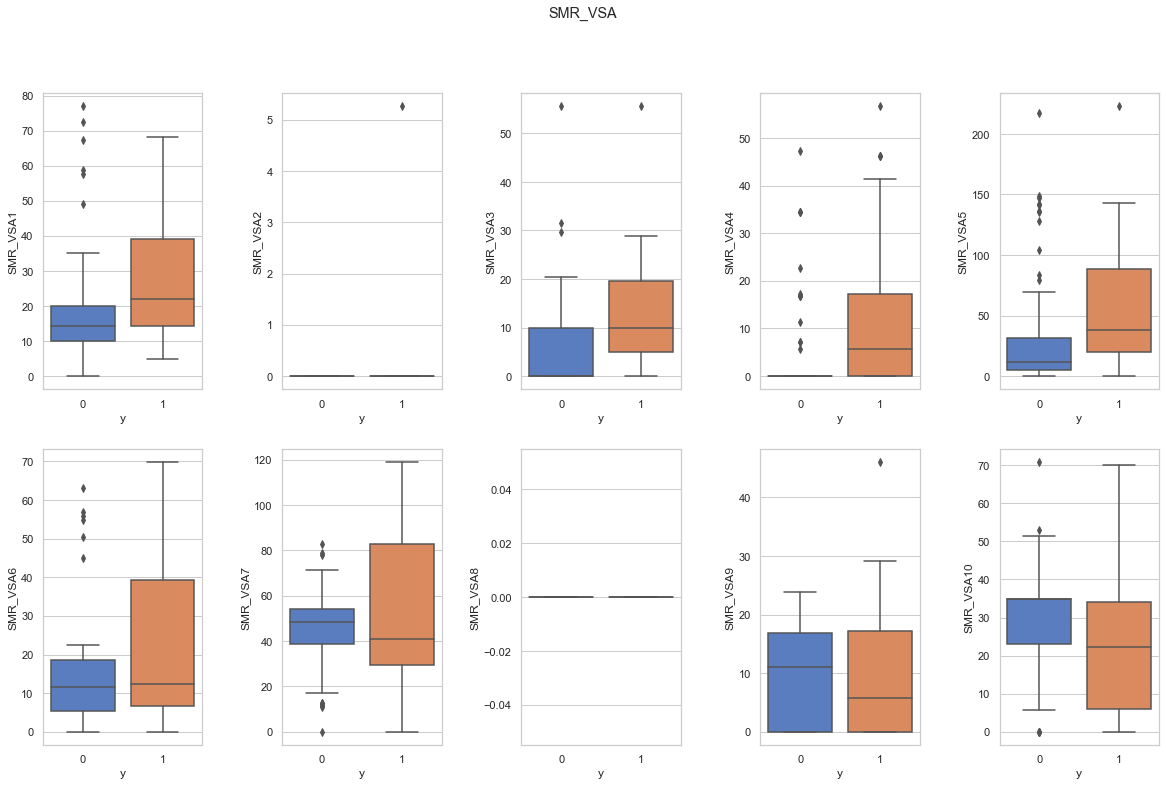

In [98]:
visualize(2, 5, (20, 12), [f'SMR_VSA{i}' for i in range(1, 11)], 'SMR_VSA')

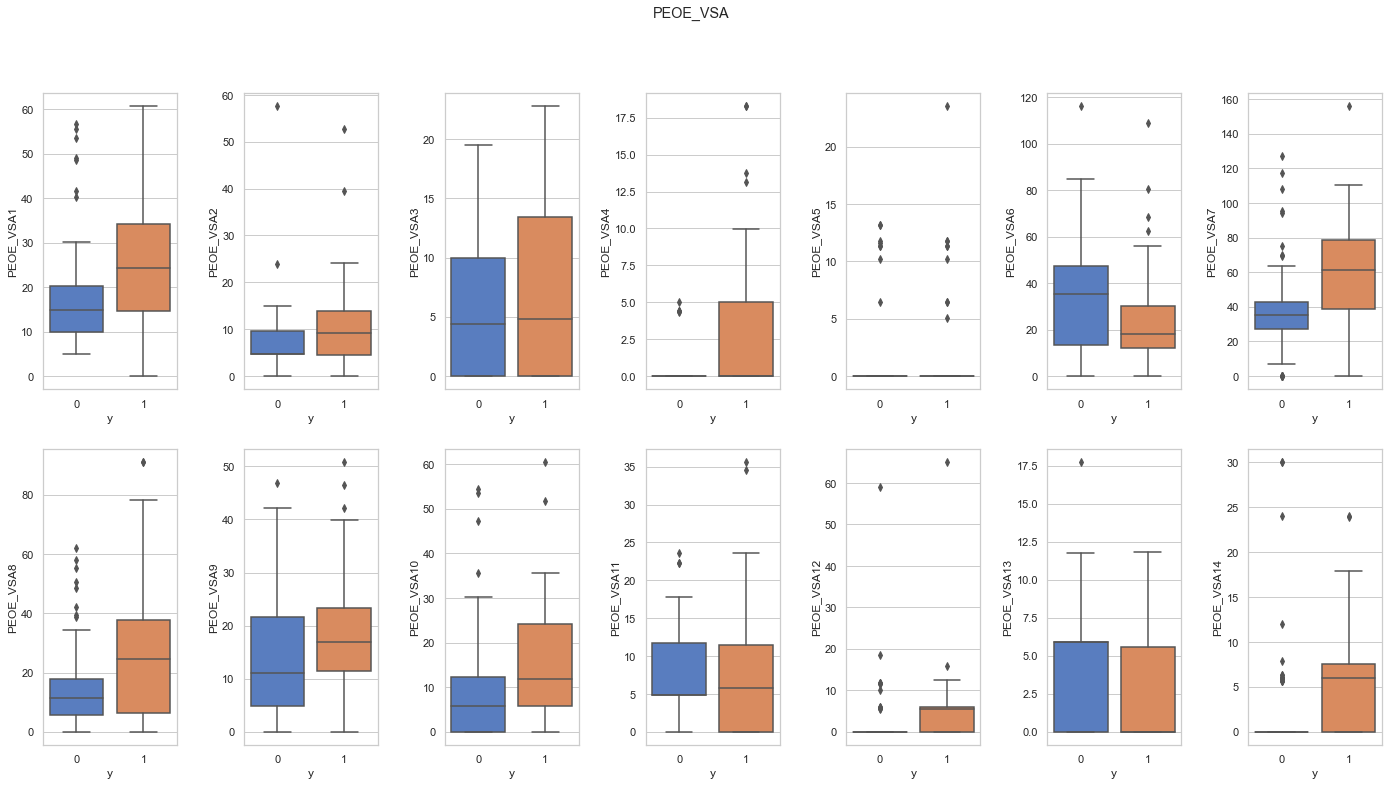

In [103]:
visualize(2, 7, (24, 12), [f'PEOE_VSA{i}' for i in range(1, 15)], 'PEOE_VSA')

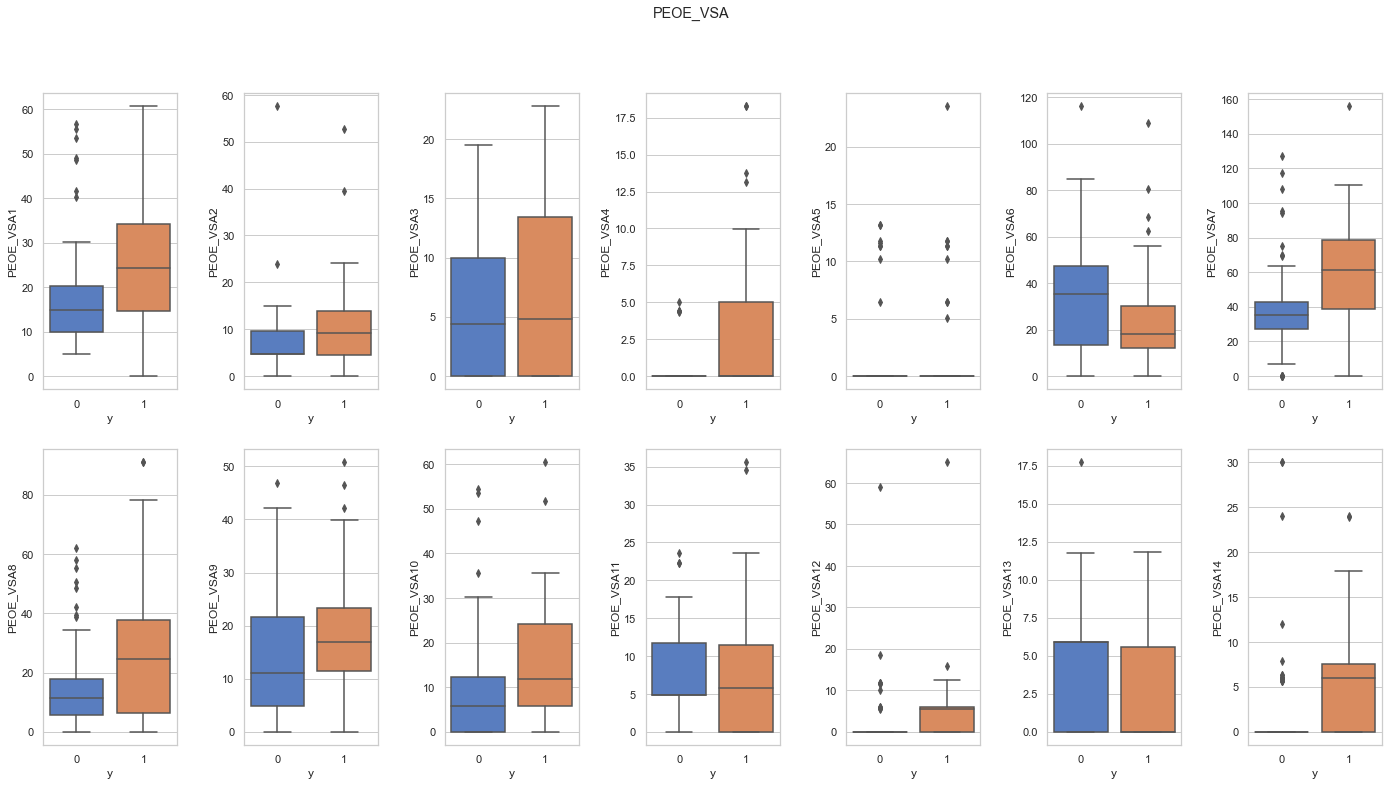

In [129]:
visualize(2, 7, (24, 12), [f'PEOE_VSA{i}' for i in range(1, 15)], 'PEOE_VSA')

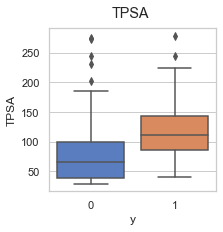

In [110]:
visualize(1, 1, (3, 3), ['TPSA'], 'TPSA')

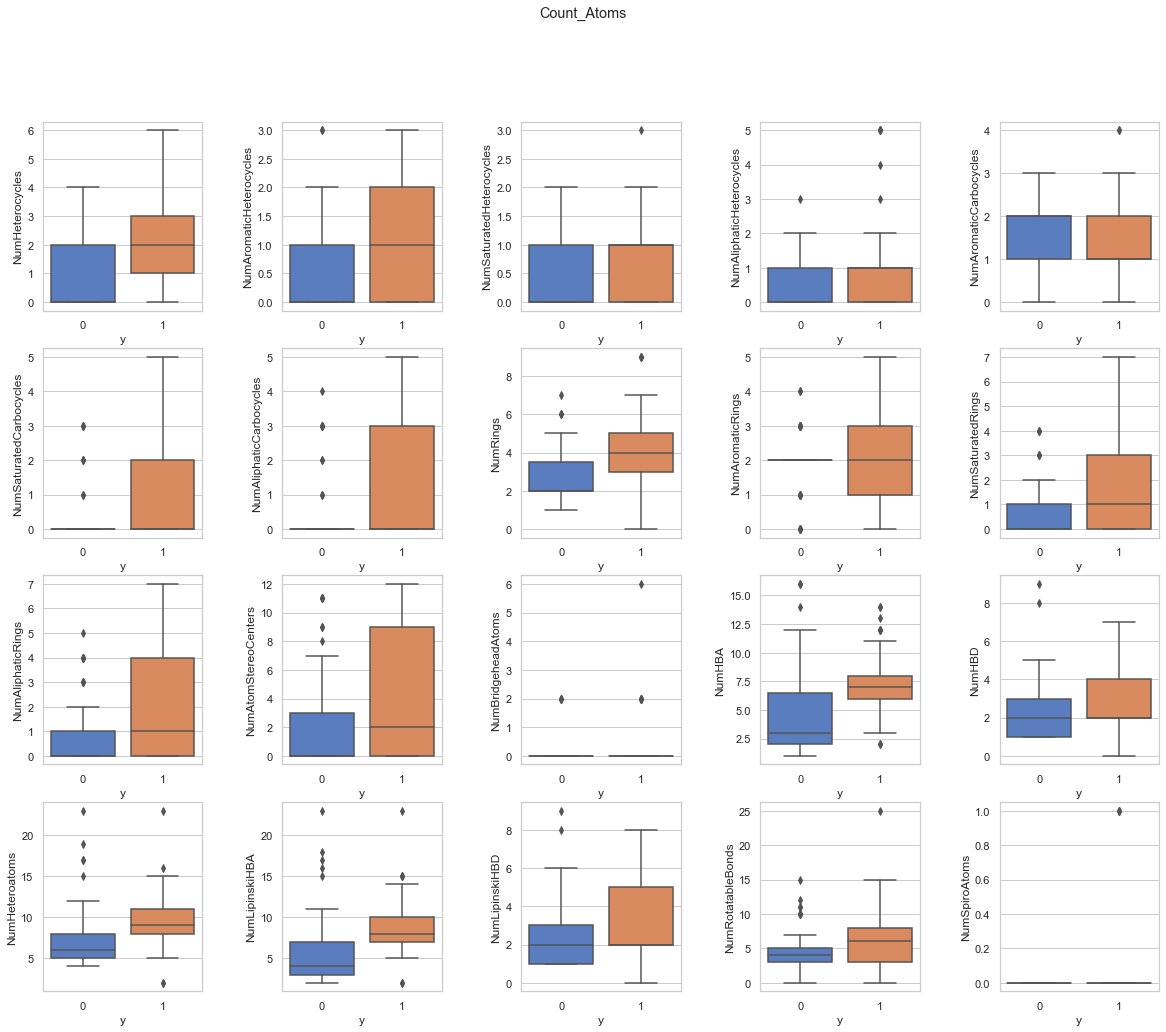

In [119]:
visualize(4, 
          5, 
          (20, 16), 
          [
              'NumHeterocycles',
              'NumAromaticHeterocycles',
              'NumSaturatedHeterocycles',
              'NumAliphaticHeterocycles',
              'NumAromaticCarbocycles',
              'NumSaturatedCarbocycles',
              'NumAliphaticCarbocycles',
              'NumRings',
              'NumAromaticRings',
              'NumSaturatedRings',
              'NumAliphaticRings',
              'NumAtomStereoCenters',
              'NumBridgeheadAtoms',
              'NumHBA',
              'NumHBD',
              'NumHeteroatoms',
              'NumLipinskiHBA',
              'NumLipinskiHBD',
              'NumRotatableBonds',
              'NumSpiroAtoms'
          ], 
          'Count_Atoms')

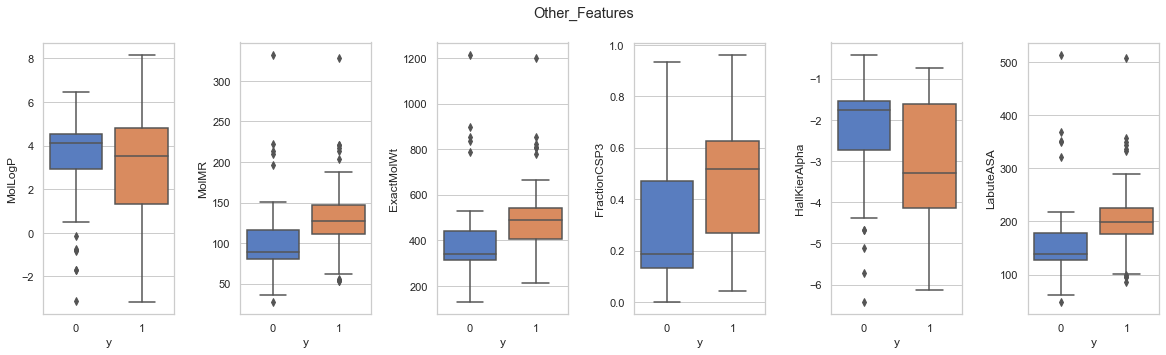

In [123]:
visualize(1, 
          6, 
          (20, 5), 
          [
              'MolLogP',
              'MolMR',
              'ExactMolWt',
              'FractionCSP3',
              'HallKierAlpha',
              'LabuteASA'
          ], 
          'Other_Features')

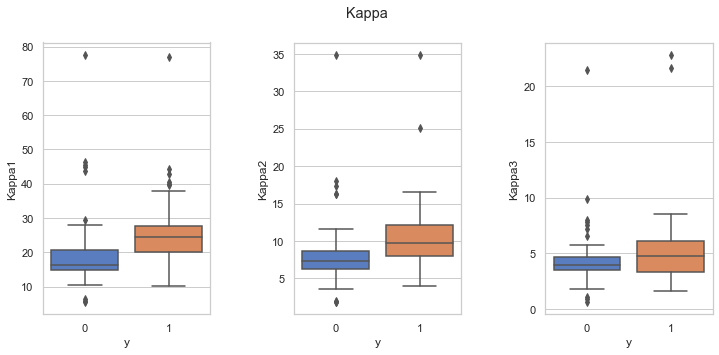

In [134]:
visualize(1, 
          3, 
          (12, 5), 
          [
              'Kappa1',
              'Kappa2',
              'Kappa3'
          ], 
          'Kappa')

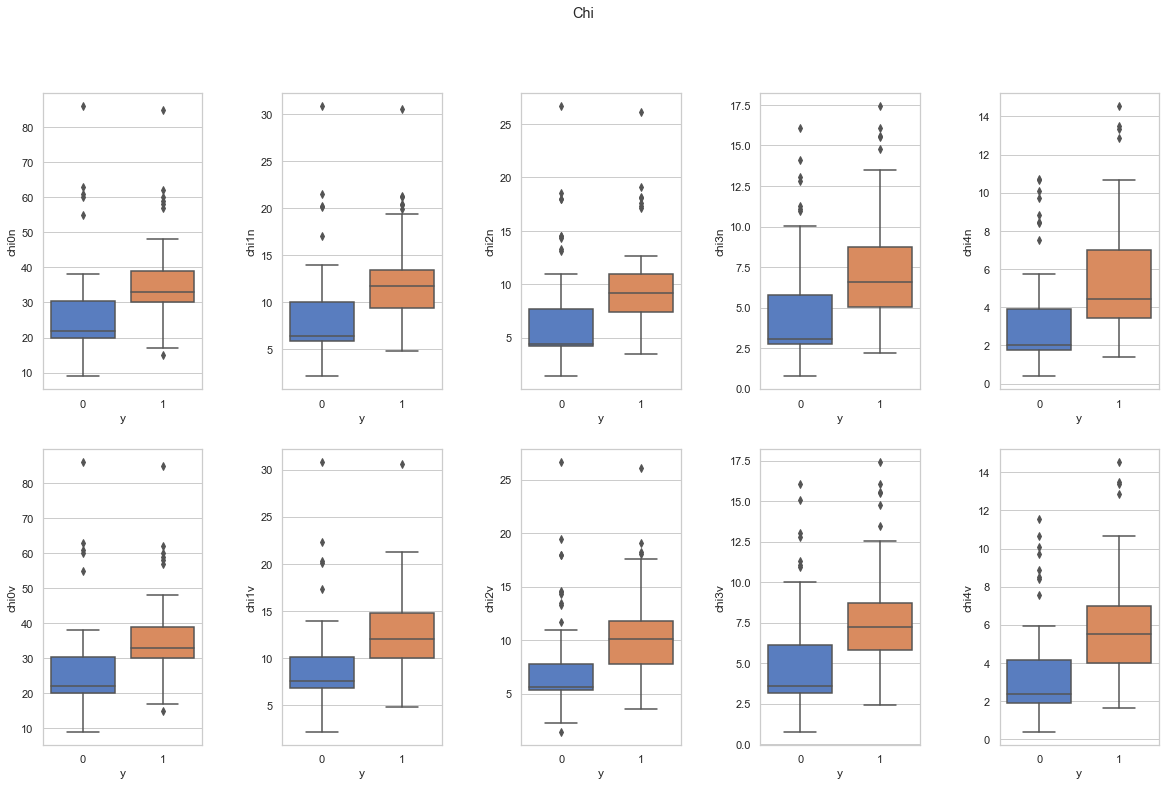

In [126]:
visualize(2, 
          5, 
          (20, 12), 
          [
              'chi0n',
              'chi1n',
              'chi2n',
              'chi3n',
              'chi4n',
              'chi0v',
              'chi1v',
              'chi2v',
              'chi3v',
              'chi4v'
          ], 
          'Chi')

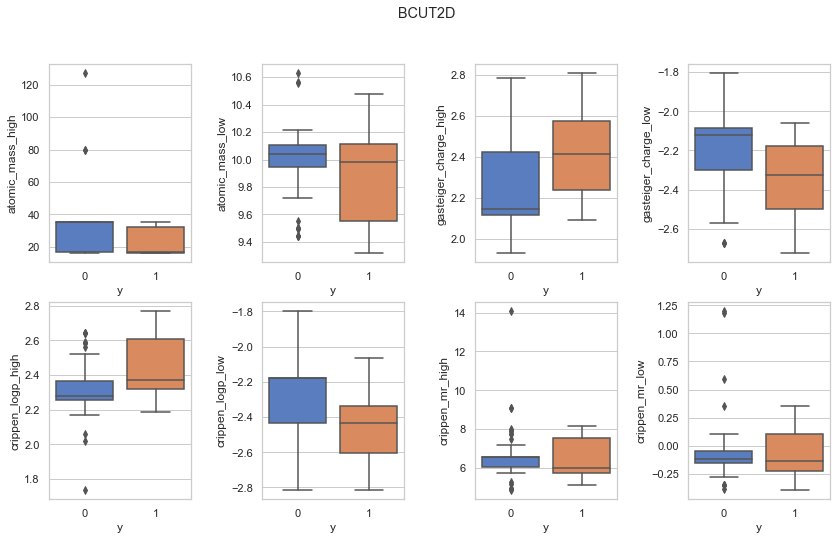

In [137]:
visualize(2, 
          4, 
          (14, 8), 
          [
              'atomic_mass_high',
              'atomic_mass_low',
              'gasteiger_charge_high',
              'gasteiger_charge_low',
              'crippen_logp_high',
              'crippen_logp_low',
              'crippen_mr_high',
              'crippen_mr_low' 
          ], 
          'BCUT2D')

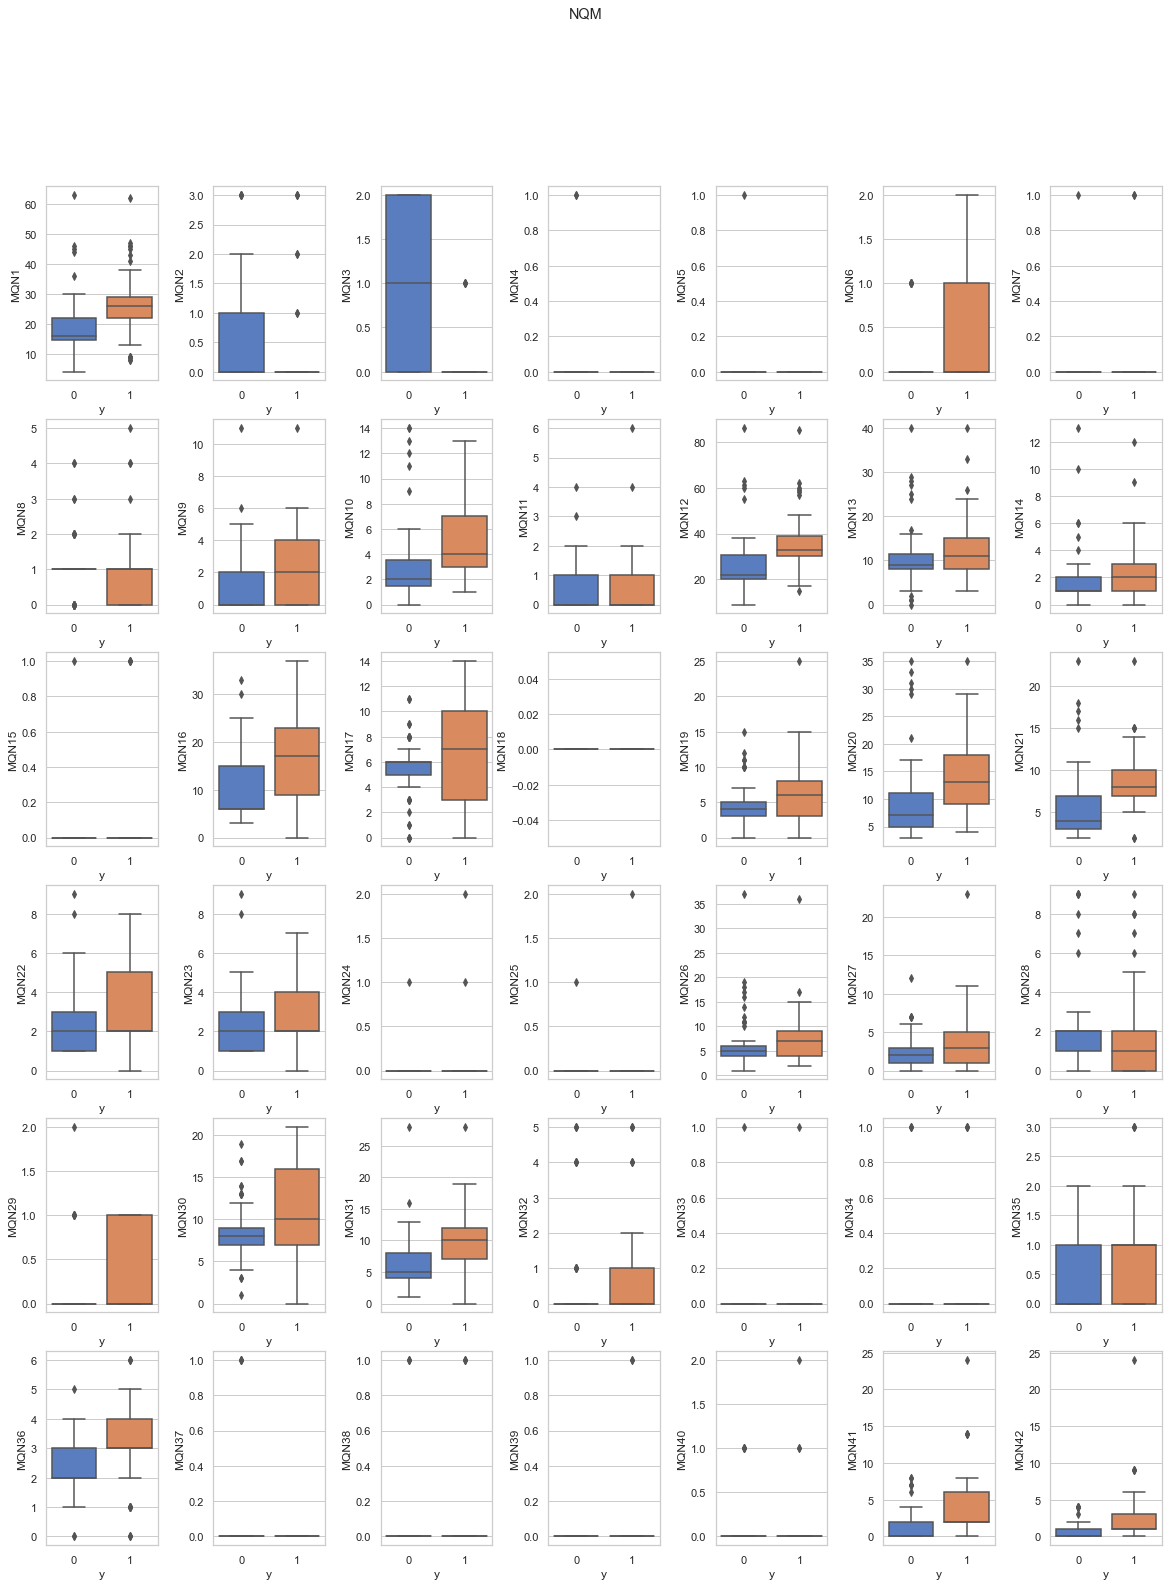

In [175]:
visualize(6, 7, (20, 25), [f'MQN{i}' for i in range(1, 43)], 'NQM')

# Processing ZZ compounds

In [176]:
c13 = "COC1=CC(C2=NC(SCC#C)=NC(NNC(N)=S)=C2C#N)=CC(OC)=C1OC"
c387 = "CC1=CC=CC=C1NC2=C(C#N)C(C3=CC=CC=C3)=NC(SCC4=CN(CC5=CC=C(Cl)C=C5)N=N4)=N2"
c404 = "ClC1=CC=CC(NC2=C(C#N)C(C3=CC=C(C(C)C)C=C3)=NC(SCC4=CN(CC(NC(NC5=CC=CC=N5)=O)=O)N=N4)=N2)=C1"
c436 = "ClC1=CC=CC(NC(N=C(SCC(NC(NC2=CC=CC=N2)=O)=O)N=C3C4=CC(OC)=C(OC)C(OC)=C4)=C3C#N)=C1"
c441 = "O=C(NC1=CC=CC=N1)NC(CSC2=NC(NC3=CC=C(Cl)C=C3)=C(C#N)C(C4=CC(OC)=C(OC)C(OC)=C4)=N2)=O"
c479 = "O=C(NC1=CC=CC=N1)NC(CSC2=NC(NC3=CC=CC([N+]([O-])=O)=C3)=C(C#N)C(C4=CC(OC)=C(OC)C(OC)=C4)=N2)=O"

In [178]:
df_zz = pd.DataFrame(columns=['compound_name', 'smiles']+feats_name)
df_zz.loc[:, 'compound_name'] = ['c13', 'c387', 'c404', 'c436', 'c441', 'c479']
df_zz.loc[:, 'smiles'] = [c13, c387, c404, c436, c441, c479]

for index, row in df_zz.iterrows():
    df_zz.loc[index, 2:] = rdk_features(row['smiles'])
df_zz.head()

/Users/Jphild/anaconda3/envs/mrp7pred/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  


,compound_name,smiles,atomic_mass_high,atomic_mass_low,gasteiger_charge_high,gasteiger_charge_low,crippen_logp_high,crippen_logp_low,crippen_mr_high,crippen_mr_low,...,MQN33,MQN34,MQN35,MQN36,MQN37,MQN38,MQN39,MQN40,MQN41,MQN42
0,c13,COC1=CC(C2=NC(SCC#C)=NC(NNC(N)=S)=C2C#N)=CC(OC...,32.1666,10.0556,2.20526,-2.16013,2.41734,-2.34346,7.98893,0.324398,...,0,0,0,2,0,0,0,0,0,0
1,c387,CC1=CC=CC=C1NC2=C(C#N)C(C3=CC=CC=C3)=NC(SCC4=C...,35.4957,10.071,2.17469,-2.13681,2.31609,-2.04147,7.97917,0.64921,...,0,0,1,4,0,0,0,0,0,0
2,c404,ClC1=CC=CC(NC2=C(C#N)C(C3=CC=C(C(C)C)C=C3)=NC(...,35.4957,9.99287,2.18235,-2.13484,2.3228,-2.36401,7.97918,-0.120225,...,0,0,1,4,0,0,0,0,0,0
3,c436,ClC1=CC=CC(NC(N=C(SCC(NC(NC2=CC=CC=N2)=O)=O)N=...,35.4957,10.0528,2.2164,-2.16174,2.42133,-2.35264,7.99346,-0.116949,...,0,0,0,4,0,0,0,0,0,0
4,c441,O=C(NC1=CC=CC=N1)NC(CSC2=NC(NC3=CC=C(Cl)C=C3)=...,35.4957,10.0528,2.21601,-2.16146,2.42112,-2.35264,7.99346,-0.116949,...,0,0,0,4,0,0,0,0,0,0


In [179]:
df_zz.to_csv('./data/featurized_zz.csv', index=False)